<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/34_fMNIST_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

In [59]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

in_colab = 'google.colab' in sys.modules   # check if note is executed within Colab

# Forces tensorflow version (only in colab)
if in_colab:
    %tensorflow_version 2.x           

# Clone the repository if executed in Google Colab
if in_colab:  
    if "MLPy2021" in os.listdir():
        !git -C MLPy2021 pull
    else:
        !git clone https://github.com/munich-ml/MLPy2021/

# lib.helper_funcs.py. The import path depends on Colab or local execution 
if in_colab:
    from MLPy2021.lib.helper_funcs import pickle_out
else: 
    from lib.helper_funcs import pickle_out

Already up to date.


# The data

## Load the data


In [60]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

## Scale the data

In [61]:
from sklearn.base import TransformerMixin,BaseEstimator

class MaxScaler(BaseEstimator,TransformerMixin):

    def fit(self, X, y=None):
        self._scale = X.max()
        return self

    def transform(self, X):
        return X / self._scale

In [62]:
scaler = MaxScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

## Split the data

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                      test_size=5000)

## Reshape the data
Convolutional layers require 4-dim data

In [64]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# The model


## Create the model

In [65]:
# Reuse model from ageron: https://github.com/ageron/handson-ml2
def create_model_ageron():
    layers = [
        keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding="same", input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation='softmax')]
    return keras.models.Sequential(layers)

In [66]:
# Reuse model from cmasch: https://github.com/cmasch/zalando-fashion-mnist/
def create_model_cmasch():
    layers = [
        keras.layers.InputLayer(input_shape=[28, 28, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Dropout(0.1),
        keras.layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding="same"),
        #keras.layers.Conv2D(filters=128, kernel_size=4, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units=256, activation="relu"),
        #keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=256, activation="relu"),
        #keras.layers.Dense(units=128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(units=10, activation='softmax')]
    return keras.models.Sequential(layers)

In [67]:
model = create_model_cmasch()
#model = create_model_ageron()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 64)         

## Compile the model

In [68]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam", metrics=["accuracy"])

The `learning_rate` is set within the optimizer. Here, the default is taken:

In [69]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

## Train the model

In [70]:
X_train.shape

(55000, 28, 28, 1)

In [71]:
X_valid.shape

(5000, 28, 28, 1)

In [72]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5241 - accuracy: 0.8125 - val_loss: 0.3056 - val_accuracy: 0.8876
Epoch 2/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3471 - accuracy: 0.8743 - val_loss: 0.2685 - val_accuracy: 0.9002
Epoch 3/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3094 - accuracy: 0.8876 - val_loss: 0.2433 - val_accuracy: 0.9114
Epoch 4/20
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2822 - accuracy: 0.8966 - val_loss: 0.2463 - val_accuracy: 0.9088
Epoch 5/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2644 - accuracy: 0.9041 - val_loss: 0.2295 - val_accuracy: 0.9134
Epoch 6/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2511 - accuracy: 0.9076 - val_loss: 0.2260 - val_accuracy: 0.9152
Epoch 7/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2338 - accuracy: 0.9165 - val_loss: 0.2206 - val_ac

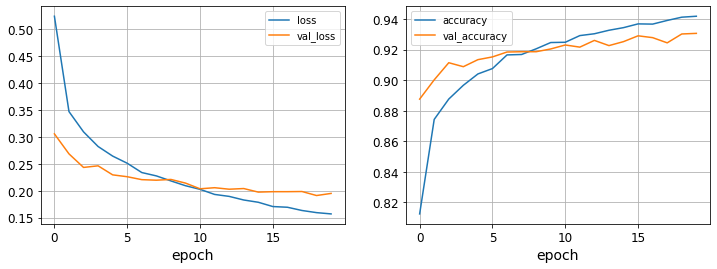

In [85]:
fig = plt.figure(figsize=[12, 4]) 
axes = fig.subplots(nrows=1, ncols=2)
for i, word in enumerate(["loss", "accuracy"]):
    for key, vals in history.history.items():
        if word in key:
            axes[i].plot(vals, label=key)
for ax in axes:
    ax.grid(), ax.legend(), ax.set_xlabel("epoch")

# Save model and testset


## Mount google drive

In [74]:
mount_dir = os.path.join(os.getcwd(), "drive")
mount_dir

'/content/drive'

In [75]:
from google.colab import drive
drive.mount(mount_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## model.save()


In [76]:
save_dir = os.path.join(mount_dir, "My Drive", "Colab Notebooks", "models")
save_dir

'/content/drive/My Drive/Colab Notebooks/models'

In [77]:
fn = "fMNIST_CNN_v5_cmasch"
model.save(os.path.join(save_dir, fn + ".h5"))

## Save validation and test data along with the model

In [78]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [79]:
pickle_out(os.path.join(save_dir, fn + "_data.pkl"), locals(),
           X_valid, y_valid, X_test, y_test, class_names)

# Evaluate

In [80]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 0.1950 - accuracy: 0.9306


[0.19502706825733185, 0.9305999875068665]